In [130]:
# %load general_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]


Now that all my general steps are loaded, time to load up the general GNB from Ch. 5 to get started

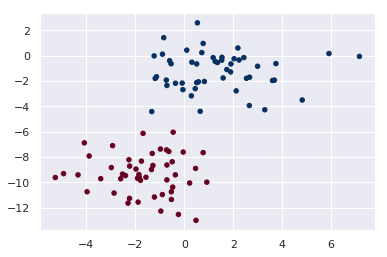

In [88]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='RdBu');

Step 1 was to make blobs; the next move is to use this as "true" data, and then generate a whole bunch of other data and use the "true" data to predict the status of the "new" data

(-5.894294701901266,
 7.781307053448095,
 -13.781702780106356,
 3.3692127846266002)

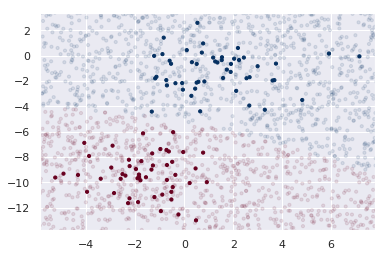

In [89]:
# Imports
from sklearn.naive_bayes import GaussianNB

# Code
model = GaussianNB()
model.fit(X, y)
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=10, cmap='RdBu', alpha=0.1)
plt.axis(lim)

That's all well and good, but I need to work out how to do this for my data

One way would be to randomly select X number of exoplanets from each category ("too cold"/"too hot"/"just right") and - using this "training" data - plot them as blobs (w/ 3 centres, not 2) and then use the rest as "test data" and see how well it predicts them.

I'm gonna try that, but I'm unconvinced that's the most optimal method of doing so. That might be a fault of my method, or it may be the case that GNB is just somewhat not the best concept for my trials - either way, not gonna know unless I do

Get some "training data"

I'm going to do this - perhaps the long way - by:

1: Creating three new arrays of "too hot", "too cold", "just right"  
2: Separate each of those into _X and _Y  
3: Use the Test-Train split functionality (from test_train_split)  

This then gives me a sample of "testing" and "training" from each group. I can then plot each "training" dataset
as the 3 "blobs", and then using those as "correct" values, then plot the rest... wait a sec...

I spy a problem.

If I just plot the rest of them as-is, they're ALREADY separated into the three categories (hot/cold/right), essentially meaning
that my entire test is useless. What I'm doing is taking 100 balls, of either R/G/B colours, separating them by colour, taking
a sample of each and putting them into distinct boxes, and then putting the rest into boxes depending on their colours... which tells
me NOTHING that I didn't ALREADY KNOW by virtue of PRE-SEPARATING THEM
 
As such, take above plan, and add in the following step:

4: RECOMBINE all the "testing" data arrays back into one big array
 
This, essentially, gives me a complete list of the REST of the exoplanets. Then, I can use THAT dataset to predict!

BOOYA!

In [131]:
# Make the Datasets

just_right = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 0].drop("kepoi_name",axis=1).copy()
too_hot = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 1].drop("kepoi_name",axis=1).copy()
too_cold = goldilocks_dataset[goldilocks_dataset["gold_temp"] == -1].drop("kepoi_name",axis=1).copy()

# Split into X and Y

jrX = just_right.drop(["koi_teq", "gold_temp"], axis=1).copy()
jrY = just_right["gold_temp"]

thX = too_hot.drop(["koi_teq", "gold_temp"], axis=1).copy()
thY = too_hot["gold_temp"]

tcX = too_cold.drop(["koi_teq", "gold_temp"], axis=1).copy()
tcY = too_cold["gold_temp"]

First of all, can you run a GNB with three centers? Is that possible? (Also, colourmap uses 'RdBu' which is Red-Blue. I'd like a 'Red-Green-Blue' as this, thematically, gives us a 'Hot-Right-Cold' colour display

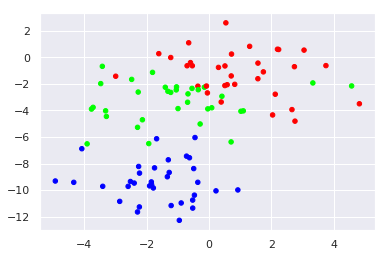

In [37]:
X, y = make_blobs(100, 2, centers=3, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='brg');   # Used "brg" colourmap

Hot damn! (Or, 'just-right' damn! HAHAHAHAHAHAHAHAHAHAHAHAHAHA) It works!

In [132]:
display(goldX.head())
display(too_hot.head())

,Planetary Radius [Earth radii],Insolation Flux [Earth flux],Stellar Radius [Solar radii]
0,1.86,2.00,1.187
1,2.53,13.18,0.720
2,2.29,186.31,0.815
3,28.41,283.07,13.056
4,1.40,18.86,0.836


,koi_prad,koi_teq,koi_insol,koi_srad,gold_temp
1,2.53,486.0,13.18,0.720,1
2,2.29,942.0,186.31,0.815,1
3,28.41,1046.0,283.07,13.056,1
4,1.40,531.0,18.86,0.836,1
5,1.40,696.0,55.36,1.465,1


In [133]:
# Splitting the hot/cold/right arrays into test and train data
hotX_train, hotX_test, hotY_train, hotY_test = train_test_split(thX, thY, random_state=1)
coldX_train, coldX_test, coldY_train, coldY_test = train_test_split(tcX, tcY, random_state=1)
rightX_train, rightX_test, rightY_train, rightY_test = train_test_split(jrX, jrY, random_state=1)

In [134]:
# Testing
testingX = pd.concat([hotX_test, coldX_test, rightX_test])
testingY = pd.concat([hotY_test, coldY_test, rightY_test])

# Training
trainingX = pd.concat([hotX_train, coldX_train, rightX_train])
trainingY = pd.concat([hotY_train, coldY_train, rightY_train])
trainingX.head()

,koi_prad,koi_insol,koi_srad
1804,1.87,4.79,0.818
783,1.14,487.47,0.966
1755,1.42,54.13,0.953
527,1.51,687.21,1.574
1477,2.16,14.88,1.480


This is good! Although, as it seems, because the arrays are _concatenated_, hot/cold/right appear in chunks. I don't want this (I dunno if this would affect the prediction algorithm, but I'd rather have them reordered based on original index, ascending (from 1-9999, etc). There is a Pandas reindex feature; let's explore that

(cue internet searching; results below)

In [135]:
# Testing
testingX = testingX.reindex(testingX.index.sort_values())
testingY = testingY.reindex(testingY.index.sort_values())

# Training
trainingX = trainingX.reindex(trainingX.index.sort_values())
trainingY = trainingY.reindex(trainingY.index.sort_values())

# Visualise
display(testingX.head())
display(trainingX.head())

,koi_prad,koi_insol,koi_srad
0,1.86,2.00,1.187
1,2.53,13.18,0.720
4,1.40,18.86,0.836
9,1.66,95.61,0.688
12,1.23,206.55,0.781


,koi_prad,koi_insol,koi_srad
2,2.29,186.31,0.815
3,28.41,283.07,13.056
5,1.40,55.36,1.465
6,2.12,283.62,0.986
7,1.44,499.41,1.220


Booya!

Okay, time to break down the make_blobs function to see what goes where

In [87]:
# From https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

make_blobs(10,#         # The number of entries to make
           3,#          # n_features, ie, how many features each entity has
           centers=3,#      # how many clusters you want
           random_state=2,#   # enable random state for reproducability
           cluster_std=1.5)#   # standard deviation of clusters

(array([[ -1.31029627,  -9.46588444,  -0.25600736],
        [ -1.14723186, -11.51282118,   1.08065559],
        [ -7.6588777 ,   4.00551468,  -9.24462797],
        [ -0.55765881,  -1.92179853,  -3.85586524],
        [ -0.17078345, -11.61682281,  -0.67284208],
        [ -5.48912524,   3.88449721,  -4.00687435],
        [ -1.97712431,  -4.77943547,  -2.56860622],
        [ -1.46756801,  -2.64508546,  -5.47739371],
        [ -4.00195461,   1.65159699,  -5.77089087],
        [ -0.55997469,  -8.9009896 ,   2.80895181]]),
 array([0, 0, 2, 1, 0, 2, 1, 1, 2, 0]))

But, like, this _generates data_ that _becomes_ the blobs -- I _already have the data_ to become blobs...

### Bollocks let's do K-means! That seems to be the best combo-ing off from the blobs

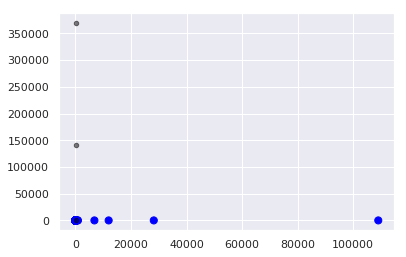

In [193]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(trainingX)
y_kmeans = kmeans.predict(trainingX)

nX = list(trainingX["koi_prad"])
nY = list(trainingX["koi_srad"])

plt.scatter(nX, nY, c=y_kmeans, s=50, cmap='brg')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=0.5);

Well, erm... that sure is a couple of large outliers! Is this correct?

In [177]:
max(y_kmeans)

2

In [178]:
max(nY)

152.969

In [180]:
max(nX)

109061.0

Yup, okay, so we just have a couple of HUGE planets... but why does the centers plot go stupidly high?

In [194]:
centers

array([[9.59214046e+01, 5.63783382e+02, 1.56282312e+00],
       [1.41775000e+01, 1.42081092e+05, 1.05712500e+01],
       [1.00000000e+01, 3.69989680e+05, 8.76900000e+00]])

Uhhh.... 1.42081092e+05??? That's..... where the *!&$ did that come from?